In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import pathlib

from tensorflow.keras import layers
from IPython.display import display, clear_output
from PIL import Image

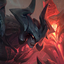

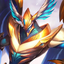

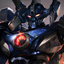

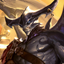

In [2]:
data_dir = pathlib.Path("./data/league-portraits/portraits")
data_file_paths = list(data_dir.glob("*.jpg"))

def convert_from_image(image):
    image.thumbnail((64, 64), Image.ANTIALIAS)
    return np.array(image).astype(np.float32) * (1 / 255)

def convert_to_image(data):
    data = (data * 255).astype(np.uint8)
    return Image.fromarray(data)


for entry in data_file_paths[:4]:
    image = Image.open(entry)
    data = convert_from_image(image)
    display(convert_to_image(data))

In [3]:
BATCH_SIZE = 64
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)
training_data_generator = image_generator.flow_from_directory(
    directory="./data/league-portraits/",
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode=None,
    interpolation="bicubic",
)

Found 1205 images belonging to 1 classes.


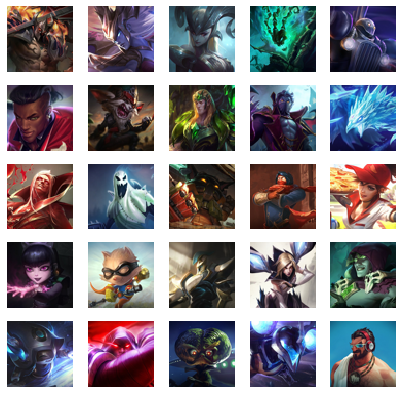

In [4]:
def render_image_batch(batch):
    plt.figure(figsize=(7, 7))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(batch[i])
        plt.axis("off")
    plt.show()

render_image_batch(next(training_data_generator))

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(
        IMAGE_WIDTH // 4 * IMAGE_HEIGHT // 4 * 256,
        use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((IMAGE_WIDTH // 4, IMAGE_HEIGHT // 4, 256)))

    model.add(layers.Conv2DTranspose(
        128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(
        3, (5, 5), strides=(2, 2), padding="same", use_bias=False,
        activation="tanh"))
    return model

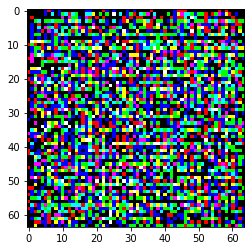

In [6]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(convert_to_image(generated_image[0].numpy()))

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00097589]], shape=(1, 1), dtype=float32)


In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoint_dir = "./training-checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "league-portrait-gan")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [21]:
def train(dataset, epochs, last_epoch=0):
    batches_per_epoch = len(dataset)

    for epoch in range(last_epoch, last_epoch + epochs):
        start = time.time()
        
        current_batch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            current_batch += 1
            if current_batch >= batches_per_epoch:
                break
        
        print(f"g_loss: {gen_loss} | d_loss: {disc_loss}")
        
        if (epoch + 1) % 15 == 0:
            clear_output(wait=True)

        generate_and_save_images(generator, epoch + 1, seed)
        
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Time for epoch {epoch + 1} is {time.time() - start}")

    checkpoint.save(file_prefix=checkpoint_prefix)
    generate_and_save_images(generator, epochs, seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(convert_to_image(predictions[i].numpy()))
        plt.axis("off")

    try:
        os.makedirs("out/league-portraits-gan")
    except:
        pass

    plt.savefig("out/league-portraits-gan/epoch_{:04d}.png".format(epoch))
    plt.show()

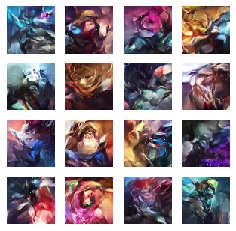

Time for epoch 58305 is 3.794015884399414
g_loss: 1.05691659450531 | d_loss: 1.1576992273330688


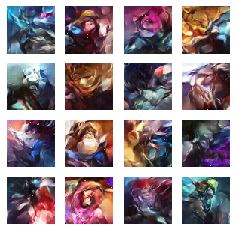

Time for epoch 58306 is 3.825756549835205
g_loss: 1.1759052276611328 | d_loss: 0.98138427734375


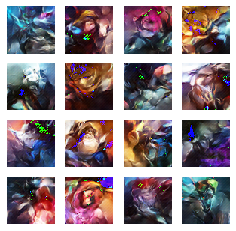

Time for epoch 58307 is 3.965235948562622
g_loss: 0.689276933670044 | d_loss: 1.3694339990615845


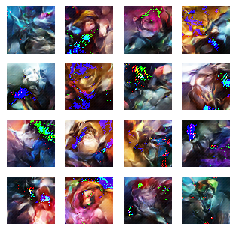

Time for epoch 58308 is 3.931630849838257
g_loss: 1.225306510925293 | d_loss: 1.2124402523040771


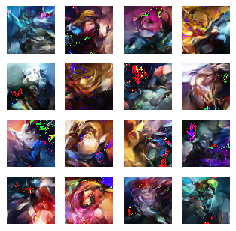

Time for epoch 58309 is 4.250970363616943
g_loss: 1.0348036289215088 | d_loss: 1.0651001930236816


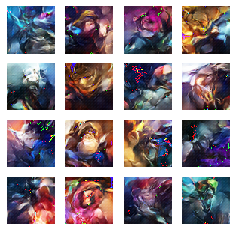

Time for epoch 58310 is 3.8710451126098633
g_loss: 0.6587520241737366 | d_loss: 1.4071722030639648


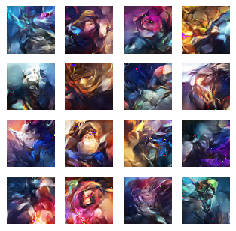

Time for epoch 58311 is 3.922750473022461
g_loss: 1.2895654439926147 | d_loss: 1.0204386711120605


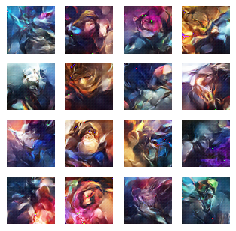

Time for epoch 58312 is 3.878568649291992
g_loss: 1.0924277305603027 | d_loss: 1.0894368886947632


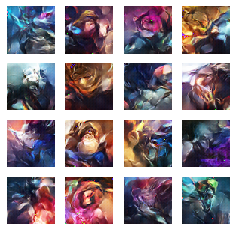

Time for epoch 58313 is 3.8622989654541016
g_loss: 0.8892432451248169 | d_loss: 1.2268470525741577


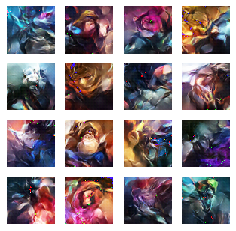

Time for epoch 58314 is 4.005234003067017
g_loss: 1.127899408340454 | d_loss: 1.5012598037719727


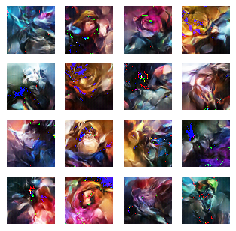

Time for epoch 58315 is 3.681572437286377
g_loss: 0.9241126179695129 | d_loss: 1.2175688743591309


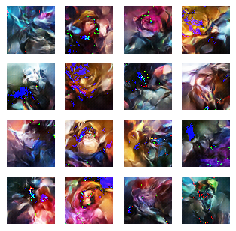

Time for epoch 58316 is 3.915156841278076
g_loss: 1.0984468460083008 | d_loss: 1.218456745147705


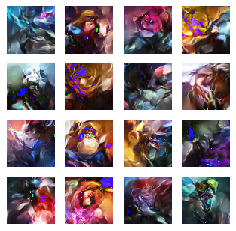

Time for epoch 58317 is 3.8630006313323975
g_loss: 0.9069815278053284 | d_loss: 1.2461154460906982


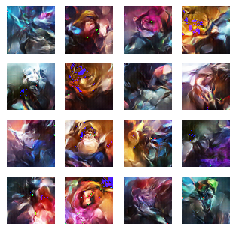

Time for epoch 58318 is 3.793999433517456


In [ ]:
train(training_data_generator, 200000, last_epoch=40050)